 **Прогнозирование заказов такси**






**Описание проекта**
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Инструкция по выполнению проекта:\
1) Загрузите данные и выполните их ресемплирование по одному часу.\
2) Проанализируйте данные.\
3)Обучите разные модели с различными гиперпараметрами.

Сделайте тестовую выборку размером 10% от исходных данных.
Проверьте данные на тестовой выборке и сделайте выводы.

# Загрузка данных

In [41]:
!pip install catboost -q
!pip install lightgbm -q
!pip install  scikit-learn -q

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col = 'datetime')

except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime'])

df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


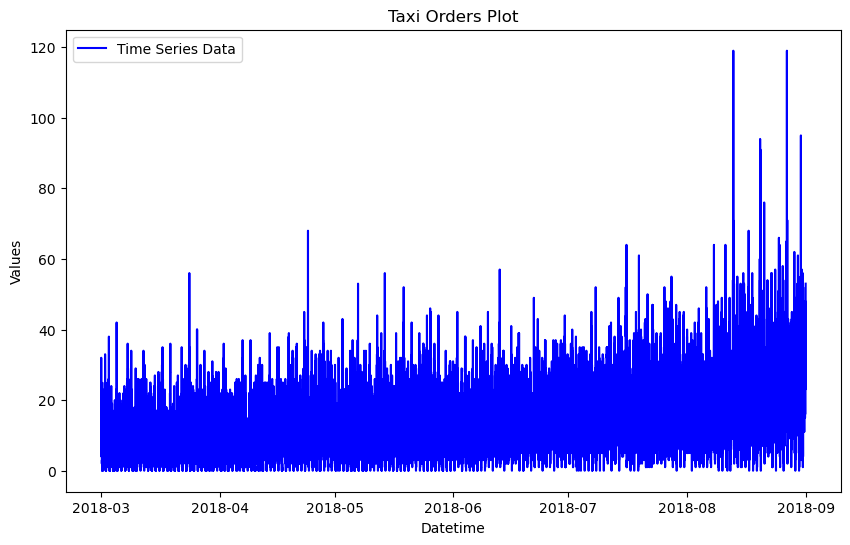

In [4]:
plt.figure(figsize=(10, 6))
plt.plot( df['num_orders'], label='Time Series Data', color='blue')
plt.title('Taxi Orders Plot')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.legend()
plt.show()


In [5]:
df_resampled = df.resample('1H').sum()

**Вывод**: На этапе загрузки данных был загружен датасет с историческими данными заказов такси в аэропортах. После чего было проведено ресемплирование данных по одному часу.

# Анализ данных

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

array([[<AxesSubplot: title={'center': 'num_orders'}>]], dtype=object)

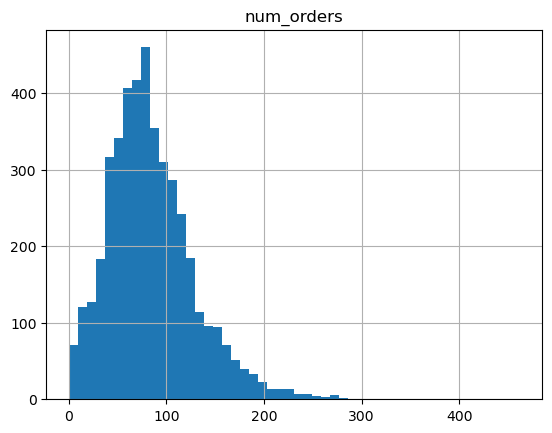

In [6]:
display(df_resampled['num_orders'].describe());
display(df_resampled.hist(bins=50))

Максимальное количество заказов в час - 77\
Среднее количество заказов в час - 14


## Скользящее среднее ряда

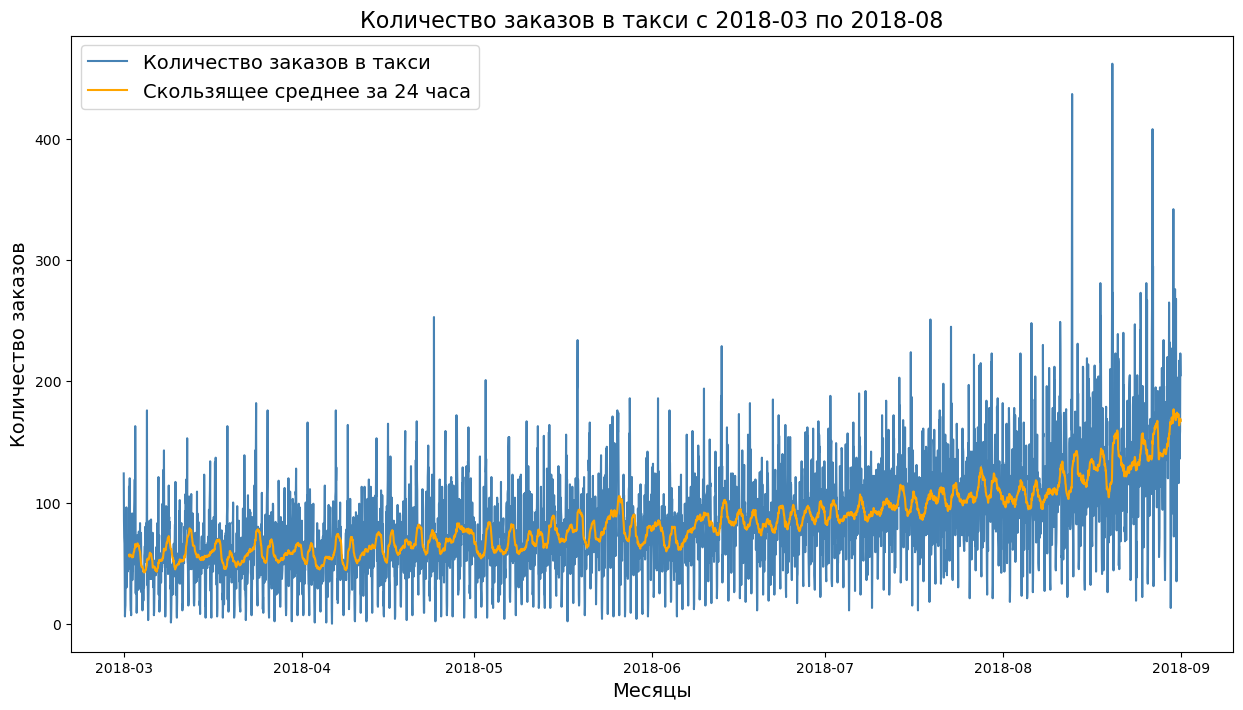

In [7]:
# зададим размер графика
plt.figure(figsize = (15,8))

plt.plot(df_resampled, label = 'Количество заказов в такси', color = 'steelblue')
plt.plot(df_resampled.rolling(window = 24).mean(), label = 'Скользящее среднее за 24 часа', color = 'orange')

plt.legend(title = '', loc = 'upper left', fontsize = 14)

# добавим подписи к осям и заголовки
plt.xlabel('Месяцы', fontsize = 14)
plt.ylabel('Количество заказов', fontsize = 14)
plt.title('Количество заказов в такси с 2018-03 по 2018-08', fontsize = 16)

# выведем обе кривые на одном графике
plt.show()

## Тренд, сезонность, остатки временного ряда

In [8]:
df_resampled.index.is_monotonic

C:\Users\Иван\AppData\Local\Temp\ipykernel_8080\3000980321.py:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  df_resampled.index.is_monotonic


True

In [9]:
df_resampled.index.is_unique

True

Данные не имеют дубликатов по времени

Проведем анализ временного ряда на тренд, сезонную составляющую и остаток декомпозиции

In [10]:
decomposed = seasonal_decompose(df_resampled)

In [11]:
def plot_trend_season_residuals_of_ts(decomposed_data):
  line_styles = ['-', ':', '-.']
  colors = ['blue', 'green', 'red']

  plt.figure(figsize=(14, 10))

# Подграфик для тренда
  plt.subplot(311)
  decomposed_data.trend.plot(ax=plt.gca(), linestyle=line_styles[0], color=colors[0])
  plt.title('Trend')
  plt.xlabel('')
  plt.ylabel('')

  # Подграфик для сезонности
  plt.subplot(312)
  decomposed_data.seasonal.plot(ax=plt.gca(), linestyle=line_styles[1], color=colors[1])
  plt.title('Seasonality')
  plt.xlabel('')
  plt.ylabel('')

  # Подграфик для остатков
  plt.subplot(313)
  decomposed.resid.plot(ax=plt.gca(), linestyle=line_styles[2], color=colors[2])
  plt.title('Residuals')

  # Общий заголовок
  plt.suptitle('Time Series Decomposition', fontsize=16)
  plt.tight_layout()
  plt.show()

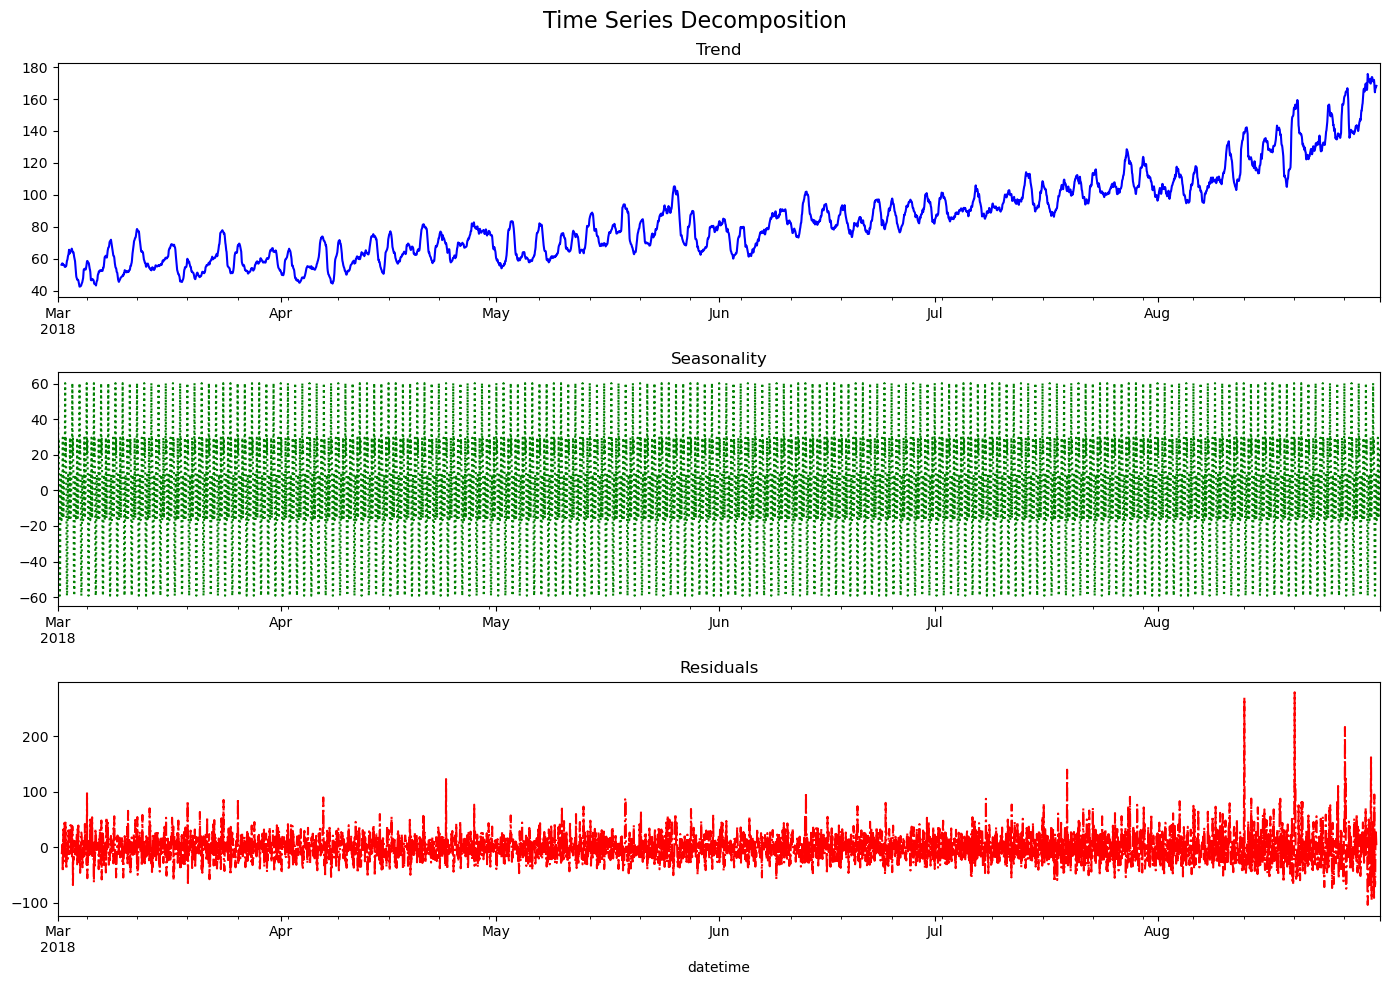

In [12]:
plot_trend_season_residuals_of_ts(decomposed_data=decomposed)

Тренд датасета показывает что количество заказов в такси растет от марта к лету, т.е. летом количество заказов выросло по сравнению с мартом

Для анализа сезонности сделаем срез в данных за период в неделю

In [13]:
week_df_resampled = df['2018-03-01':'2018-03-07'].resample('1H').mean()

In [14]:
week_decomposed = seasonal_decompose(week_df_resampled)

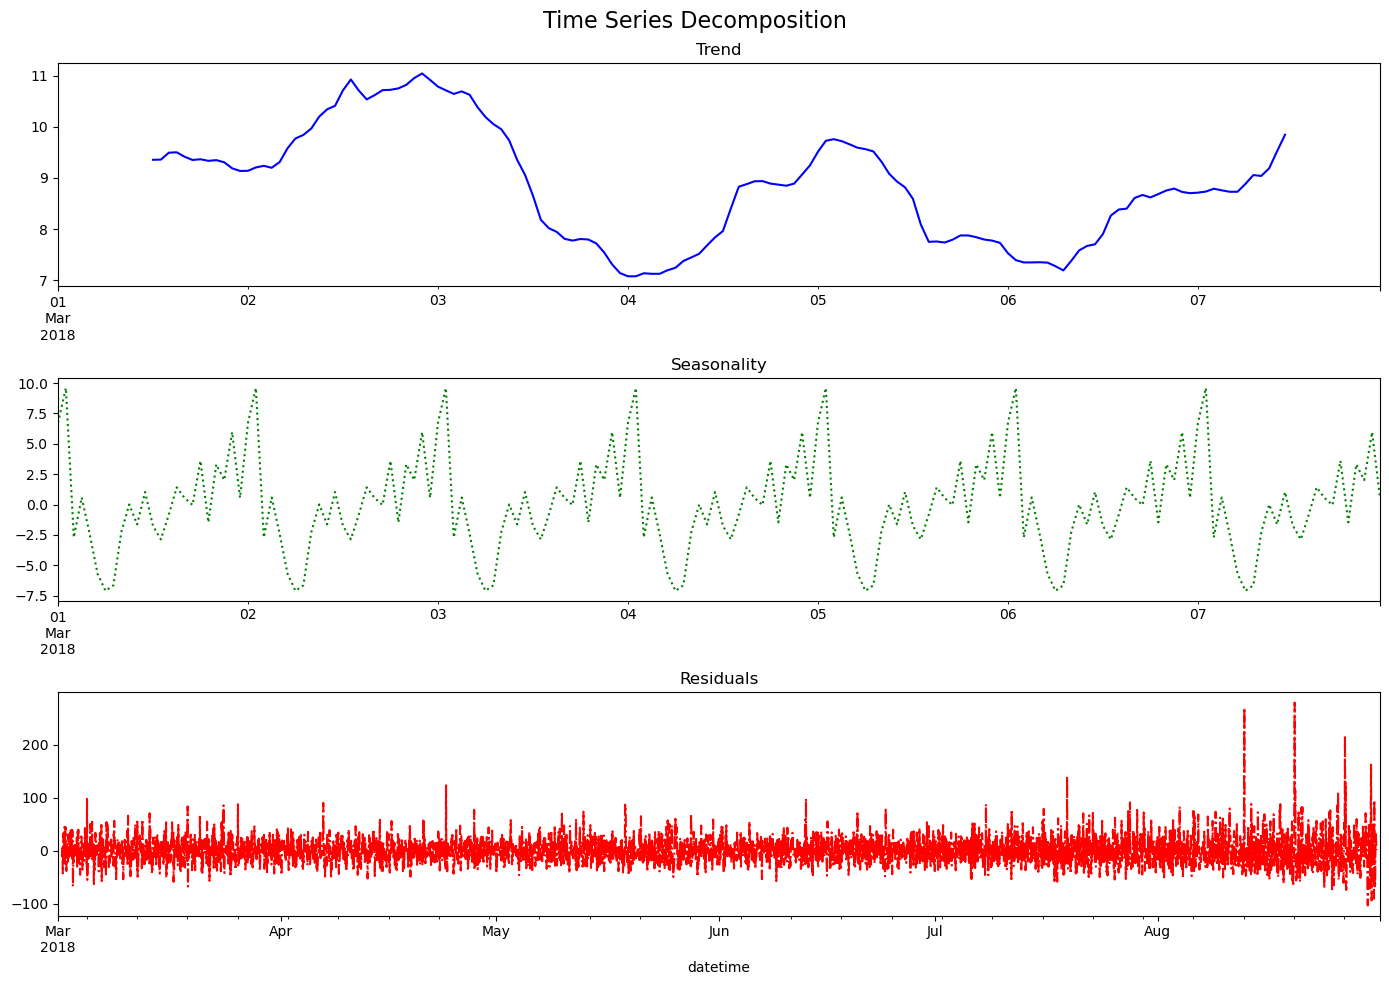

In [15]:
plot_trend_season_residuals_of_ts(decomposed_data=week_decomposed)

На графике сезонности можно заметить, что пик заказов в течение дня приходит на полуночь каждого дня

## Стационарность ряда

Проверим является ли ряд стационарым или нет. Исходя из визуальной оценки тренда и сезонности ряда можно сделать вывод о том, что ряд является нестационарным так как наблюдается некий тренд и сезонность графика.\
Чтобы подтвердить или отвергнуть эту гипотезу проведем статистический тест Дики-Фулера.

В данном случае гипотезы звучат следующим образом.

- Нулевая гипотеза предполагает, что процесс нестационарный
- Альтернативная гипотеза соответственно говорит об обратном

In [16]:
adf_test = adfuller(df_resampled)

# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.028940051402613028


Как мы видим, вероятность (p-value) для данных о перевозках меньше 0,05.Соответсвенно, мы  можем отвергнуть нулевую гипотезу и сказать, что  процесс стационарный.

## Автокорреляция

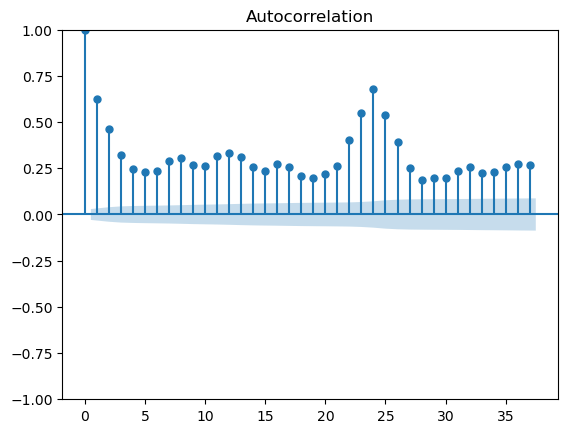

In [17]:
plot_acf(df_resampled)
plt.show()

На графике автокоррелляционной функции, можно заметить, что что 24 лаг сильнее корреллирует с исходным рядом, чем соседние лаги, что может говорить на наличии ежечасных колебаний.

**Вывод:** На данном этапе был проведен анализ временного ряда заказов такси. По итогам статистического теста Дики-Фулера можно сказать , что ряд - стационарный. АКФ показывает наличие пик заказов в промежутке с 23 до 1 часов.

# Обучение моделей

Напишем функцию которая будет создавать признаки для горизонта прогнозирования, а также календарные признаки прогнозирования(месяц, день недели, час)

## Построение признаков

In [18]:
def make_features(data, pred_label, max_lag, rolling_mean_size):
    df = data.copy()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df[pred_label].shift(lag)

    df['rolling_mean'] = df[pred_label].shift().rolling(rolling_mean_size).mean()
    
    return df


In [19]:
df_resampled = make_features(data=df_resampled, pred_label='num_orders', max_lag=48, rolling_mean_size=24)

In [22]:
df_resampled

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,...,193.0,232.0,217.0,216.0,265.0,177.0,170.0,191.0,169.0,164.875000
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,...,186.0,193.0,232.0,217.0,216.0,265.0,177.0,170.0,191.0,167.541667
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,...,56.0,186.0,193.0,232.0,217.0,216.0,265.0,177.0,170.0,168.041667


Разделим датасет на тренировочную и тестовую выборки

In [23]:
train, test = train_test_split(df_resampled, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop(columns=['num_orders'])
y_train = train['num_orders']
X_test = test.drop(columns=['num_orders'])
y_test = test['num_orders']

Отмасштабируем числовые признаки

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Линейная регрессия

In [24]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

LinearRegression()

In [25]:
lin_reg_predict = lin_reg_model.predict(X_test)

In [26]:
print(f'RMSE линейной регрессии: {mean_squared_error(y_test, lin_reg_predict, squared=False)}')

RMSE линейной регрессии: 6.395562342361705


In [27]:
lin_reg_predict = pd.DataFrame(lin_reg_predict).set_index(y_test.index)

In [32]:
def plot_pred_real_values(y_pred, y_true):
  # Создаем фигуру и оси
  fig, ax = plt.subplots(figsize=(25, 6))
  y_pred = pd.DataFrame(y_pred).set_index(y_test.index)

  # Линии для предсказанных и реальных значений
  ax.plot(y_pred, label='Предсказанные значения', color='blue', marker='o', linestyle='-', linewidth=2)
  ax.plot(y_test, label='Реальные значения', color='green', marker='o', linestyle='-', linewidth=2)

  # Добавляем фоновую сетку
  ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

  # Подписи к осям
  ax.set_xlabel('Временной ряд', fontsize=14)
  ax.set_ylabel('Значения', fontsize=14)

  # Заголовок графика
  ax.set_title('Реальные и предсказанные значения временного ряда', fontsize=16)

  # Легенда с лучшим расположением
  ax.legend(loc='best', fontsize=12)

  # Добавляем тень для линий
  ax.set_facecolor('#f0f0f0')

  # Устанавливаем стиль линий сетки на задний план
  ax.set_axisbelow(True)

  # Убираем рамку вокруг графика
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  # Отобразим график
  plt.show()


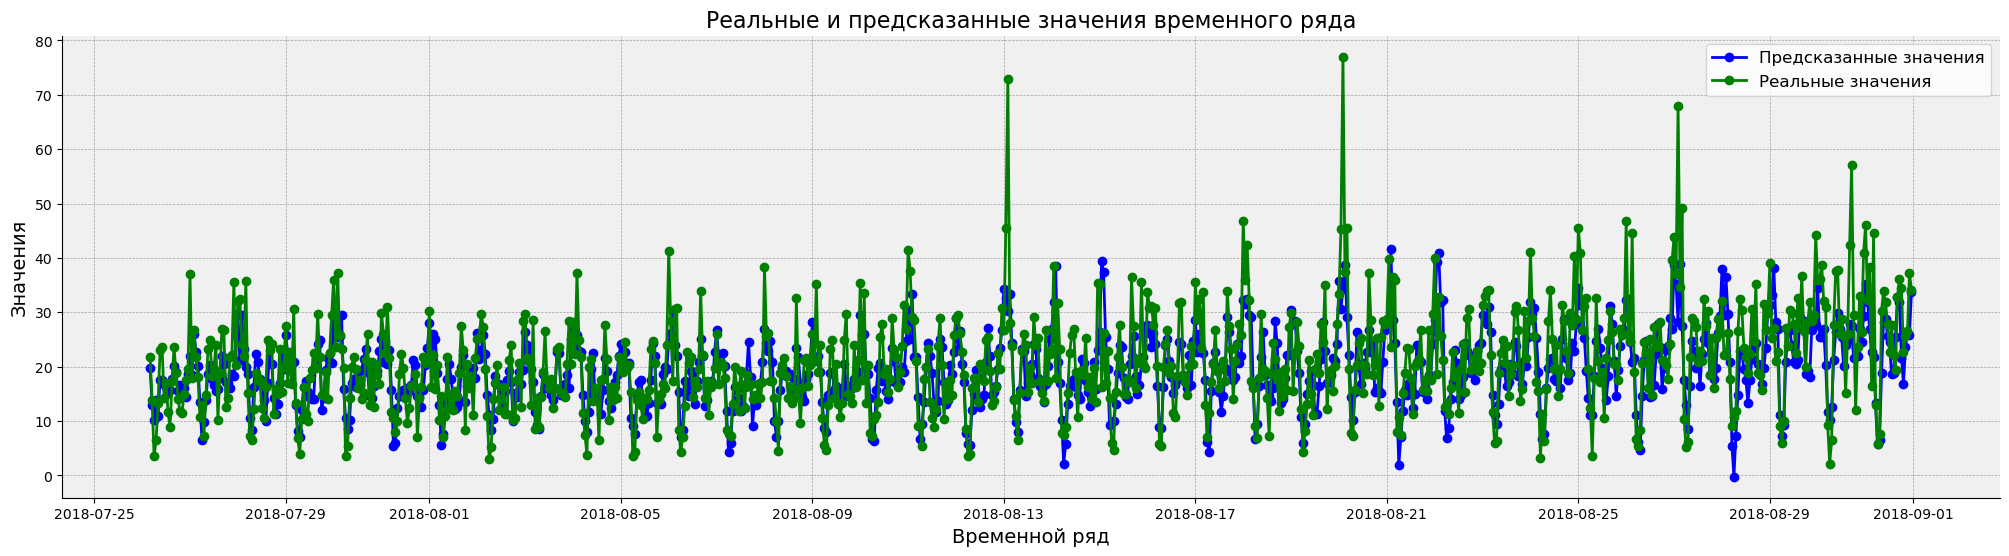

In [29]:
plot_pred_real_values(y_pred=lin_reg_predict, y_true=y_test)

Модель простой линейной регрессии показала результат RMSE= 6.39, данный результат является неплохим, по графику также видно, что модель неплохо улавливает закономерности в данных

## Lasso regression

In [30]:
lasso_model = Lasso()

## DecisionTreeRegressor


In [31]:
RANDOM_STATE = 42
dt_model = DecisionTreeRegressor(random_state=RANDOM_STATE)
cv = TimeSeriesSplit(n_splits=2)

dt_param_grid = {
                    'max_depth': range(5,15),
                    'min_samples_leaf': range(5,15),
                    'min_samples_split': range(5,15),
                    'criterion': ['squared_error', 'absolute_error']
                 }


dt_RandomSearch = RandomizedSearchCV(dt_model,
                               dt_param_grid,
                               cv=cv,
                               scoring='neg_mean_squared_error',
                               random_state=RANDOM_STATE)

In [32]:
%%time
dt_RandomSearch.fit(X_train, y_train)

CPU times: total: 10.8 s
Wall time: 10.9 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
                   estimator=DecisionTreeRegressor(random_state=42),
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': range(5, 15),
                                        'min_samples_leaf': range(5, 15),
                                        'min_samples_split': range(5, 15)},
                   random_state=42, scoring='neg_mean_squared_error')

In [33]:
print('Лучшя модель:')
display(dt_RandomSearch.best_estimator_)
print('Лучшая метрика на кросс-валидации:')
display(((dt_RandomSearch.best_score_)*-1 ) ** 0.5)

Лучшя модель:


DecisionTreeRegressor(criterion='absolute_error', max_depth=5,
                      min_samples_leaf=14, min_samples_split=10,
                      random_state=42)

Лучшая метрика на кросс-валидации:


4.98926316339199

In [34]:
dt_predict = dt_RandomSearch.best_estimator_.predict(X_test)

RMSE решающего дерева: 7.994523188914992


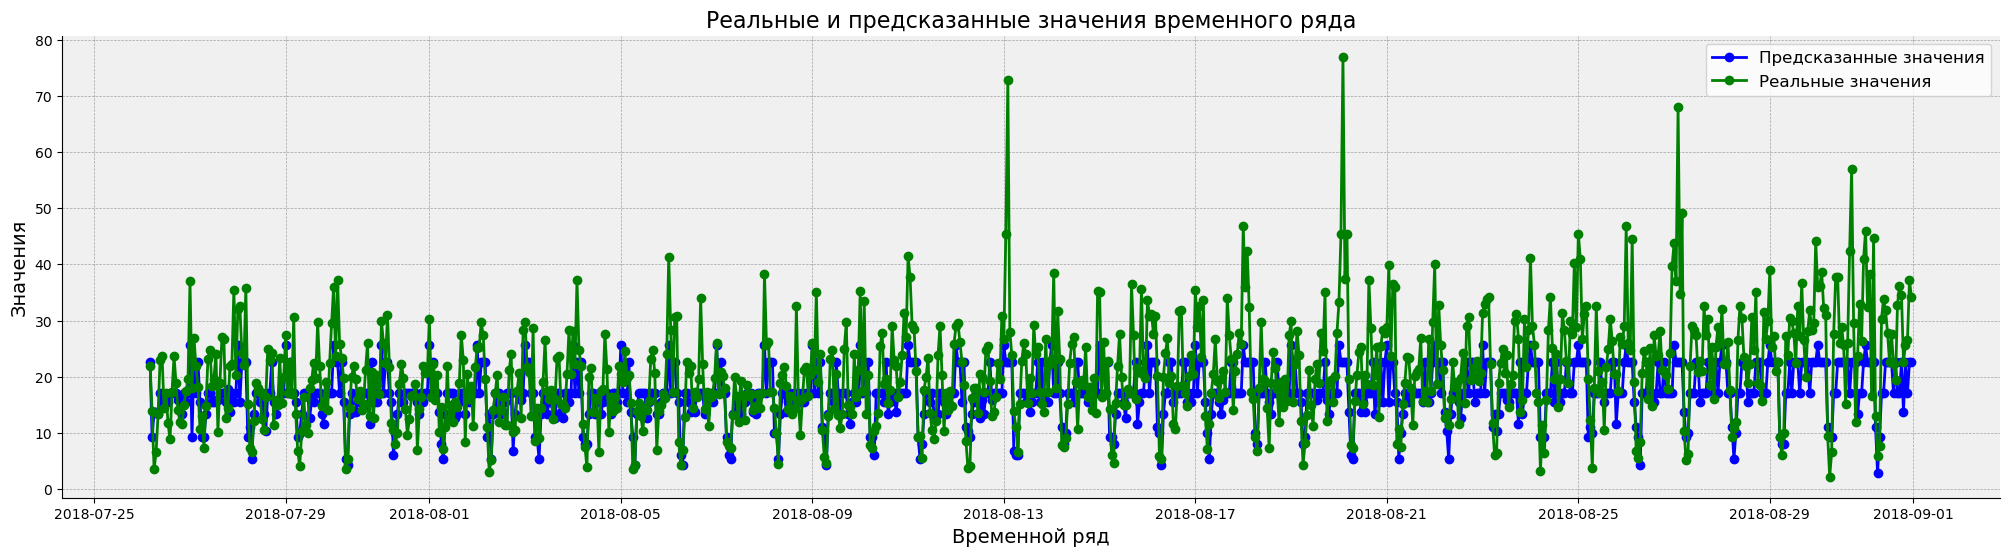

None

In [35]:
print(f'RMSE решающего дерева: {mean_squared_error(y_test, dt_predict, squared=False)}')
display(plot_pred_real_values(y_true=y_test, y_pred=dt_predict))

Как можно отметить модель решающего дерева хуже справилась с предсказанием числа заказов, чем линейная регрессия

## RandomForest

In [36]:
random_forest_model = RandomForestRegressor(random_state=RANDOM_STATE)

random_forest_param_grid = {
                            'n_estimators': [100, 500, 800]
}

cv = TimeSeriesSplit(n_splits=2)

random_forest_RandomSearch = RandomizedSearchCV(random_forest_model,
                               random_forest_param_grid,
                               cv=cv,
                               scoring='neg_mean_squared_error',
                               random_state=RANDOM_STATE)

In [37]:
random_forest_RandomSearch.fit(X_train, y_train)

C:\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
                   estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'n_estimators': [100, 500, 800]},
                   random_state=42, scoring='neg_mean_squared_error')

In [38]:
(random_forest_RandomSearch.best_score_ * -1)  ** 0.5

4.097828701407964

In [39]:
random_forest_RandomSearch.best_estimator_

RandomForestRegressor(n_estimators=500, random_state=42)

In [40]:
random_forest_predict = random_forest_RandomSearch.best_estimator_.predict(X_test)

RMSE решающего дерева: 6.835520462671503


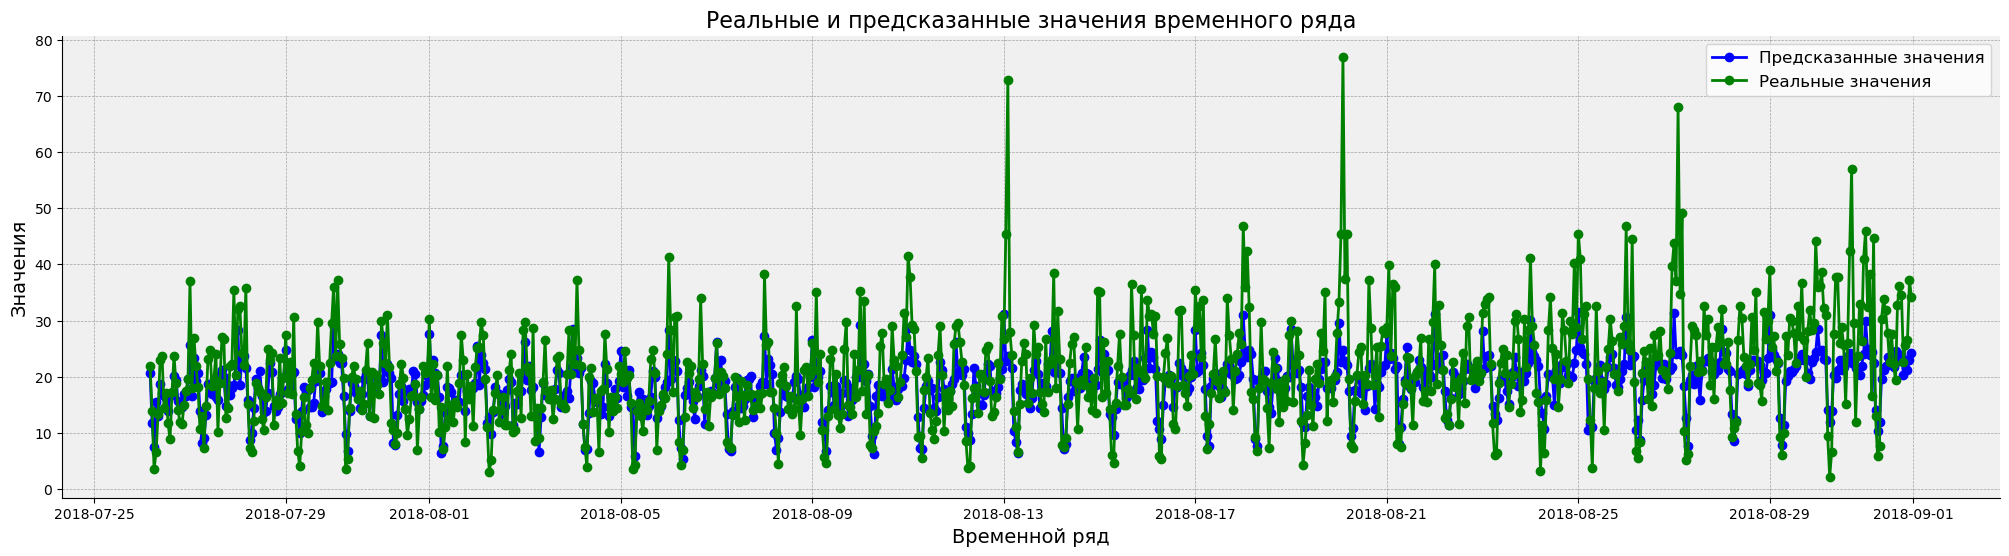

None

In [41]:
print(f'RMSE решающего дерева: {mean_squared_error(y_test, random_forest_predict, squared=False)}')
display(plot_pred_real_values(y_true=y_test, y_pred=random_forest_predict))

## Catboost

In [42]:
catboost_model = CatBoostRegressor(n_estimators=100, verbose=False)


catboost_param_grid = {
                            'n_estimators': [100, 500, 800]
}

cv = TimeSeriesSplit(n_splits=2)

catboost_RandomSearch = RandomizedSearchCV(catboost_model,
                               catboost_param_grid,
                               cv=cv,
                               scoring='neg_mean_squared_error',
                               random_state=42)

In [43]:
catboost_RandomSearch.fit(X_train, y_train,verbose=False, plot=True)

C:\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x0000025C52F13510>,
                   param_distributions={'n_estimators': [100, 500, 800]},
                   random_state=42, scoring='neg_mean_squared_error')

In [44]:
(((catboost_RandomSearch.best_score_) * -1) ** 0.5)

4.060528403931531

In [45]:
catboost_predict = catboost_RandomSearch.best_estimator_.predict(X_test)

RMSE catboost модели: 6.7491140822858275


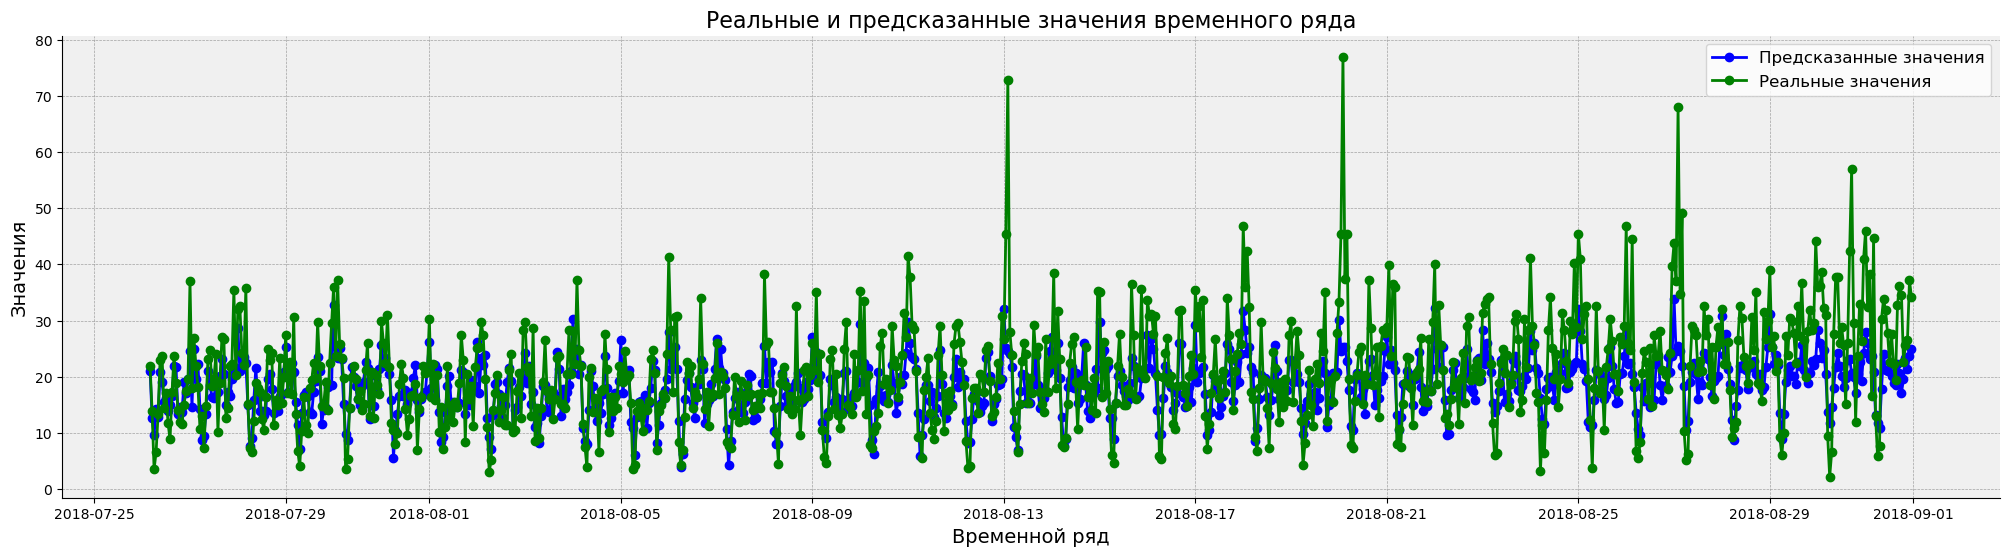

None

In [46]:
print(f'RMSE catboost модели: {mean_squared_error(y_test, catboost_predict, squared=False)}')
display(plot_pred_real_values(y_true=y_test, y_pred=catboost_predict))

catboost показала не самые лучшие результаты, не смотря на более высокую сложность алгоритма по сравнению с линейной регрессией.


# Обучение модели Sarimax

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_sarimax = train['num_orders']
test_sarimax = test['num_orders']

order = (48, 0, 0)
seasonal_order = (0, 1, 0, 48)  

model = SARIMAX(train_sarimax, 
                order = order, 
                seasonal_order = seasonal_order)

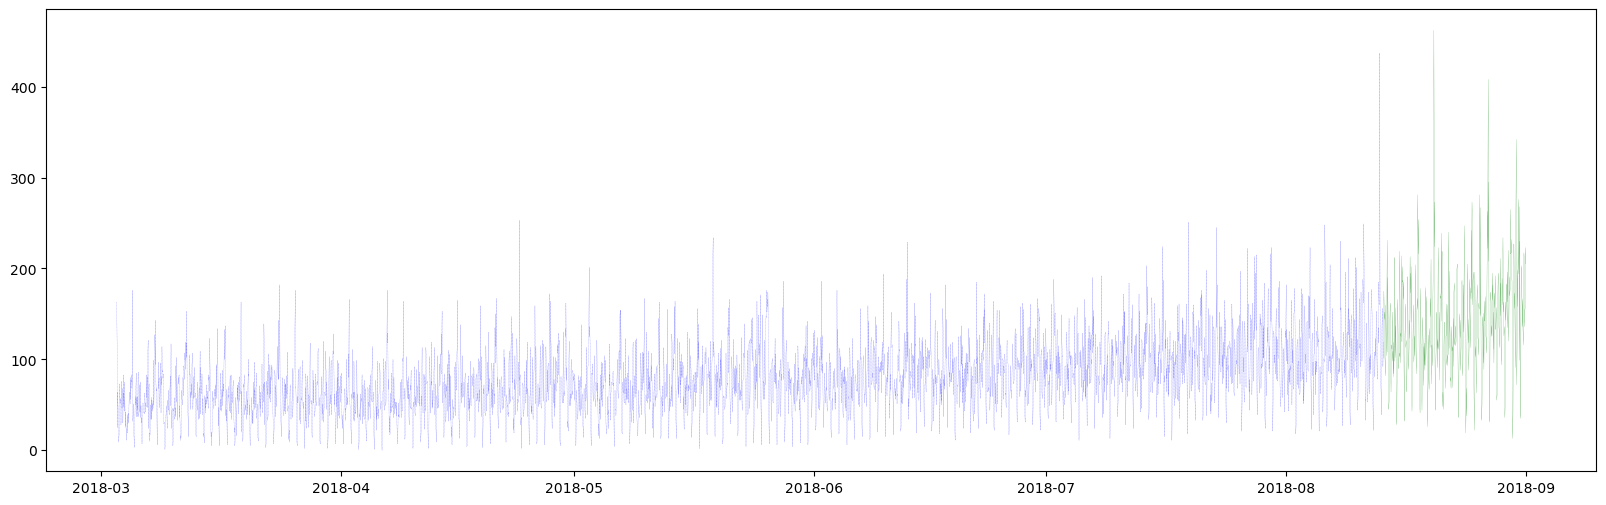

In [26]:
plt.figure(figsize=(20,6))
plt.plot(train_sarimax, color='blue',  linestyle='-.', linewidth=0.1)
plt.plot(test_sarimax, color='green',  linestyle='-', linewidth=0.1)
None

In [27]:
result = model.fit()

In [28]:
print(result.summary())


                                      SARIMAX Results                                      
Dep. Variable:                          num_orders   No. Observations:                 3926
Model:             SARIMAX(48, 0, 0)x(0, 1, 0, 48)   Log Likelihood              -18050.064
Date:                             Sun, 21 Jan 2024   AIC                          36198.128
Time:                                     13:33:12   BIC                          36505.019
Sample:                                 03-03-2018   HQIC                         36307.084
                                      - 08-13-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1024      0.014      7.391      0.000       0.075       0.130
ar.L2          0.0663      

In [29]:
forecast_steps = len(test_sarimax)  # Number of steps in the test set
forecast = result.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean


In [30]:
actual_values_test = test_sarimax

mean_squared_error(actual_values_test, forecast_mean, squared=False)

55.318410109637306

RMSE решающего дерева: 55.318410109637306


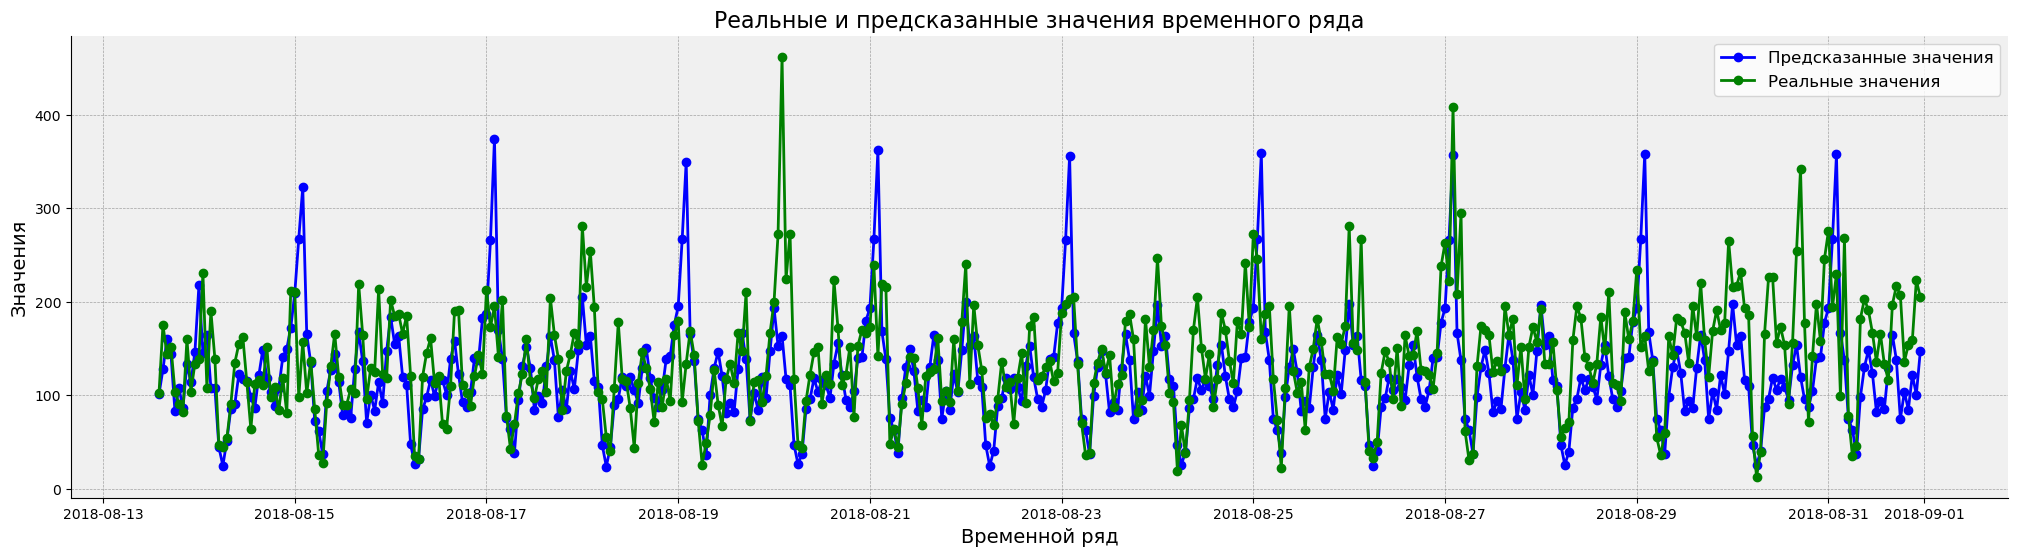

None

In [33]:
print(f'RMSE решающего дерева: {mean_squared_error(actual_values_test, forecast_mean, squared=False)}')
display(plot_pred_real_values(y_true=actual_values_test, y_pred=forecast_mean))

# Вывод


В результате работы был проведен анализ временного ряда заказов такси в период с марта 2018 по август 2018. На данном этапе был проведен анализ временного ряда заказов такси. По итогам статистического теста Дики-Фулера можно сказать , что ряд - стационарный. АКФ показывает наличие пик заказов в промежутке с 23 до 1 часов.

По результатам обучения модели лучший результат показала модели Lasso регрессии с коэффициентом регуляризации = 0.01. 